In [1]:
from PIL import Image
import glob 
import os

from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter

In [2]:
def load_dataframes(path, acc_column, sort_col_name, ascending=True):
    """
    
    Parameters
    ----------
    
    path: string,
        path to the dataframes.
    acc_column: int,
        column containing the test accuracy of the classifier.
    sort_col_name: string:
        name of the column along which to sort the dataframe entries. (Usually is the 'RP' number.)
    ascending: boolean,
        If True, sort the dataframe in ascending order. Defaults to True.
    Returns
    -------
    
    dataframes: list of DataFrames,
        list of pandas DataFrames.
    final_data: list,
        contains the data on the run with the highest accuracy.
    """
    
    allFiles = glob.glob(path + "/*.csv")
    dataframes = []
    
    for file in allFiles:
        df = pd.read_csv(file, sep='\t')
        dataframes.append(df)
    
    final_data = []

    for dataframe in dataframes:
        
        best_run_idx = dataframe[acc_column].idxmax()
        best_run = pd.DataFrame([dataframe.iloc[best_run_idx]])
        final_data.append(best_run.values)

    final_data = np.concatenate(final_data)
    best_runs = pd.DataFrame(final_data, columns=list(dataframes[0].columns.values)).sort_values(by=[sort_col_name], 
                                                                                                 ascending=ascending)
    
    return best_runs.reset_index(drop=True), dataframes, final_data

In [3]:
def normalize(df, full_model_size, bp=False):
    if bp is True:
        normalized = df["model size-tot"]/full_model_size *100
    else:
        normalized =   (df["model size [MB]"] + df["ridge size [MB]"])/full_model_size *100
    return normalized 

In [4]:
def set_title(dataset_name, model_name=None):
    
    if model_name is None:
        return "{}".format(dataset_name[0].upper() + dataset_name[1:].replace("_", " "))
        
    if model_name[:3] == "vgg":
        model_name = model_name.upper()
    
    elif model_name[:3] == "res":
        model_name = model_name[0].upper() + model_name[1:3] + model_name[3].upper() + model_name[4:]
    
    elif model_name[:3] == "den":
        model_name = model_name[0].upper() + model_name[1:5] + model_name[5].upper() + model_name[6:]
    
    return "{} - {}".format(dataset_name[0].upper() + dataset_name[1:].replace("_", " "), model_name)

In [5]:
model_name, model_options = 'densenet169', 'full'
OPU = "Saturn"
dataset = "animals10"

# path to the data folder
data_path = os.path.join("/home/luca/Desktop/TL/Blogpost/TL_blogpost/data/naive", dataset)

# path where the images will be saved
image_path = '/home/luca/Desktop/TL/Blogpost/images/'

img_format='png'

In [6]:
n_components = 2
dtype = "float16"

path_S = os.path.join(data_path, "{}_{}_brutal".format(model_name, OPU))
train, inference = {}, {}

for dtype in ("float16", "float32"):
    OPU_path = os.path.join(path_S, "OPU_{}_{}_{}".format(n_components, model_options, dtype))
    train_df, _, _ = load_dataframes(os.path.join(OPU_path, "train"), "acc_test", 'model size [MB]', ascending=False)
    inference_df, _, _ = load_dataframes(os.path.join(OPU_path, "inference"), "inference time", 'model size [MB]', ascending=False)
    train[dtype] = train_df
    inference[dtype] = inference_df
    
backprop, _, _ = load_dataframes(os.path.join(path_S, "backprop_00001"), "test accuracy", 'model size-tot', ascending=False)

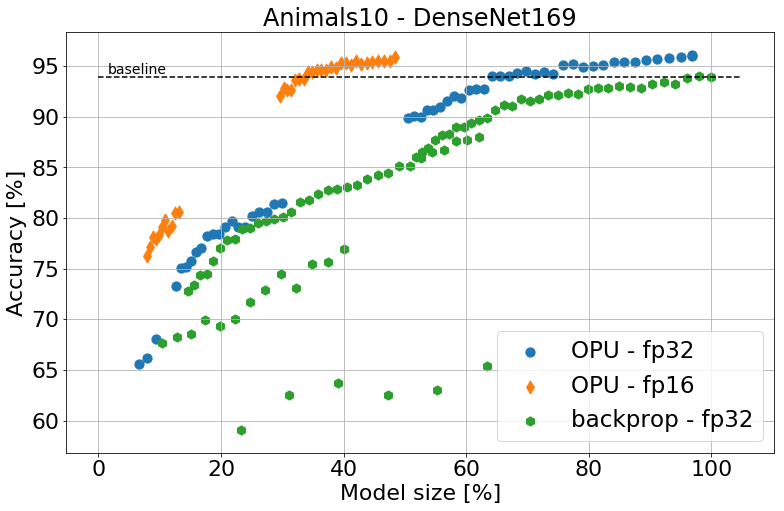

In [7]:
fsize = {'title':24, 'x':22, 'y':22, 'ticks':22, 'legend':23}

full_model_size = backprop["model size-tot"][0]
traces_x = [normalize(train["float32"], full_model_size), normalize(train["float16"], full_model_size), 
            normalize(backprop, full_model_size, bp=True)]
traces_y = [train["float32"]['acc_test'], train["float16"]['acc_test'], backprop["test accuracy"]]

trace_names = ["OPU - fp32", "OPU - fp16", "backprop - fp32"]
markers = ['o', "d", "h"]
markers_size = 85

plot_labels = {'title':set_title(dataset, model_name), 'x':"Model size [%]", 'y':"Accuracy [%]"}
            
save_path = os.path.join(image_path, "{}_{}_acc.{}".format(model_name, dataset, img_format))


fig = plt.figure(figsize=(11, 7.2))
ax = fig.gca()

for i, trace_x in enumerate(traces_x):
    ax.scatter(trace_x, traces_y[i], label=trace_names[i], marker=markers[i], s=markers_size)
    
ax.hlines(backprop["test accuracy"][0], xmin=0, xmax=105, linestyles="--")
ax.text(x=1.53, y=94.3, s="baseline", fontsize=14)

ax.grid(True)

ax.set_title(plot_labels['title'], fontsize=fsize['title'])
ax.set_xlabel(plot_labels['x'], fontsize=fsize['x'])
ax.set_ylabel(plot_labels['y'], fontsize=fsize['y'])
ax.tick_params(labelsize=fsize['ticks'])

plt.legend(fontsize=fsize['legend'])
plt.tight_layout()

if save_path is not None:
    plt.savefig(save_path, format=img_format)
plt.show()

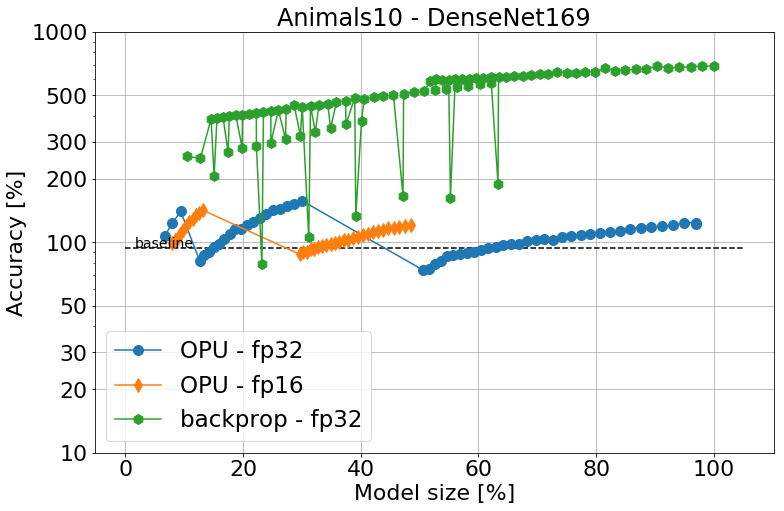

In [8]:
fsize = {'title':24, 'x':22, 'y':22, 'ticks':22, 'legend':23}

full_model_size = backprop["model size-tot"][0]
traces_x = [normalize(train["float32"], full_model_size), normalize(train["float16"], full_model_size), 
            normalize(backprop, full_model_size, bp=True)]

traces_y = [train["float32"]["total time"], train["float16"]["total time"], 
            backprop["training time"] * (backprop["epoch"] + 1)]

trace_names = ["OPU - fp32", "OPU - fp16", "backprop - fp32"]
markers = ['o', "d", "h"]
markers_size = 85

ylim = [10, 20, 30, 50, 100, 200, 300, 500, 1000]

plot_labels = {'title':set_title(dataset, model_name), 'x':"Model size [%]", 'y':"Accuracy [%]"}
            
save_path = os.path.join(image_path, "{}_{}_acc.{}".format(model_name, dataset, img_format))


fig = plt.figure(figsize=(11, 7.2))
ax = fig.gca()

for i, trace_x in enumerate(traces_x):
    ax.plot(trace_x, traces_y[i], label=trace_names[i], marker=markers[i], markersize=10)
    
ax.hlines(backprop["test accuracy"][0], xmin=0, xmax=105, linestyles="--")
ax.text(x=1.53, y=94.3, s="baseline", fontsize=14)

ax.grid(True)

ax.set_title(plot_labels['title'], fontsize=fsize['title'])
ax.set_xlabel(plot_labels['x'], fontsize=fsize['x'])
ax.set_ylabel(plot_labels['y'], fontsize=fsize['y'])

ax.tick_params(labelsize=fsize['ticks'])
ax.set_yscale("log")

ax.yaxis.set_ticks(ylim)
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.legend(fontsize=fsize['legend'])
plt.tight_layout()

if save_path is not None:
    plt.savefig(save_path, format=img_format)
plt.show()

In [9]:
dataset_path ="/home/luca/datasets/animals10/raw-img/"

In [10]:
class_images = []

for directory in os.listdir(dataset_path):
    image = Image.open(glob.glob(os.path.join(dataset_path, directory, "*.jpeg"))[0]).resize((224,224))
    class_images.append(np.array(image))

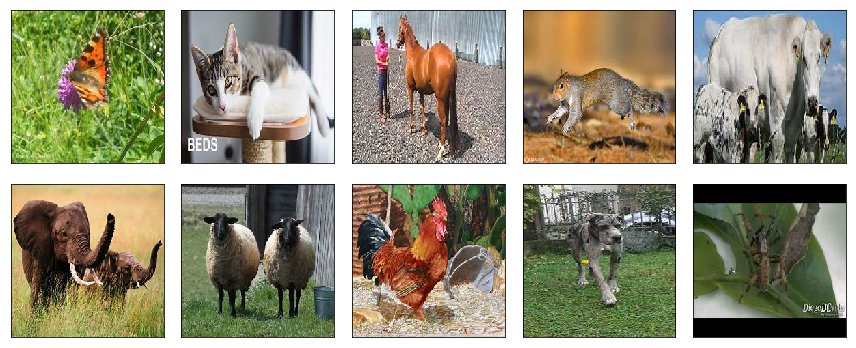

In [11]:
row, col = 2, 5
fig, ax = plt.subplots(row, col, figsize=(12,5))

for idx, image in enumerate(class_images):
    ax[idx//col, idx%col].imshow(image)
    ax[idx//col, idx%col].tick_params(axis="both", left=False, bottom=False, labelbottom=False, labelleft=False)
plt.tight_layout()
plt.savefig(os.path.join(image_path, "dataset_overview.{}".format(img_format)))
plt.show()

# For the int8 part

In [12]:
trt_columns = ["model dtype", "conv full", "conv f", "total time"]
torch_columns = ["model dtype", "conv f",  "total time"]
time_wo_conv = 58.0544
trt_path = os.path.join("/home/luca/Desktop/TL/Blogpost/TL_blogpost/data/rtx_data/",
                        "{}_{}_brutal".format(model_name, OPU))
torch_path = os.path.join("/home/luca/Desktop/TL/Blogpost/TL_blogpost/data/rtx_data_torch/",
                          "{}_{}_brutal".format(model_name, OPU))

n_components = 200000
df_trt = pd.DataFrame(columns=trt_columns)
df_torch = pd.DataFrame(columns=torch_columns)

for dtype in ("f32", "f16", "int8"):
    print(dtype)
    n_components = 2 if dtype == 'int8' else 200000
    
    OPU_path = os.path.join(trt_path, "OPU_{}_{}_{}".format(n_components, model_options, dtype))
    train_df, _, _ = load_dataframes(os.path.join(OPU_path, "train"), "acc_test", 'model size [MB]', ascending=False)
    
    train_df["total time"] = train_df["conv full"].values[0] + time_wo_conv    
    df_trt = df_trt.append(train_df[trt_columns])

    
    
for dtype in ("float32", "float16"):
    print(dtype)
    n_components = 200000
    OPU_path = os.path.join(torch_path, "OPU_{}_{}_{}".format(n_components, model_options, dtype))
    train_df, _, _ = load_dataframes(os.path.join(OPU_path, "train"), "acc_test", 'model size [MB]', ascending=False)
    
    train_df["total time"] = train_df["conv f"].values[0] + time_wo_conv
    df_torch = df_torch.append(train_df[torch_columns])

f32
f16
int8
float32
float16


In [13]:
display(df_trt)
display(df_torch)

model dtype conv full   conv f  total time
0         f32    27.379  18.8685   85.433436
0         f16   18.6016   10.338   76.656000
0        int8   15.0127  6.90479   73.067099

model dtype   conv f  total time
0     float32  32.1742   90.228635
0     float16  24.3386   82.392989